# Log Analytics - USX Manager (REST Calls Log)

This notebook provides a quick summary analytics on the REST api calls made to an USX Management Server. 

The input to this notebook could be either usx-manager-requests.log / usxm-agent-requests.log 

In [252]:
%matplotlib inline

from IPython.core.display import HTML
from IPython.display import Image

# Libraries
import apachelog, sys
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as npb
import pandas as pd
import datetime as dt
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter
from seasonal import fit_seasons, adjust_seasons, fit_trend

import seaborn as sns

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [253]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### USXM REST Calls Log

Below is the format of the log and a short description of every element:
    
    format = r'%h  %l %u %t \"%r\" %>s %b \"%i\" \"%{User-Agent}i\" %T'
    
    %V          - the server name according to the UseCanonicalName setting
    %h          - remote host (ie the client IP)
    %l          - identity of the user determined by identd (not usually used since not reliable)
    %u          - user name determined by HTTP authentication
    %t          - time the server finished processing the request.
    %r          - request line from the client. ("GET / HTTP/1.0")
    %>s         - status code sent from the server to the client (200, 404 etc.)
    %b          - size of the response to the client (in bytes)
    \"%i\"      - Referer is the page that linked to this URL.
    User-agent  - the browser identification string
    %T          - Apache request time  

#### Sample Log Statement

10.19.14.134 - - [26/Aug/2016:06:32:21 +0000] "GET /usxmanager/metrics?target=alias(summarize(*.%7BUSX_8b8419cf-9193-330e-a7f6-f8a9bbcfdc3b%7D.VolumeCapOffloadCollector.%7BCapacity_Offload_Percent%7D,%225min%22,%22avg%22),%22Deduplication%20Ratio%20(%25)%22)&from=-1hours&until=now&format=json&lineMode=connected&noCache=true&width=500&height=250&jsonp=jQuery1110014890684454986425_1472191760944&_=1472191761024 HTTP/1.1" 200 - "https://10.19.12.100:8443/index.html" "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/52.0.2743.116 Safari/537.36" 24


In [254]:
# Functions
def dash2nan(x):
    if x == '-':
        x = np.nan
    else:
        x = int(x)/1024
    return x

def gmet(x):
    x = x.split()
    return x[0]

def read_web_log(filename):
    # Create format
    logformat =  r"%h %l %u %t \"%r\" %>s %b \"%{Referer}i\" \"%{User-agent}i\" %T"

    # Create parser
    logparser = apachelog.parser(logformat)
    
    log = open(filename).readlines()
    log_list = []
    for line in log:
       try:
          data = logparser.parse(line)
       except:
          sys.stderr.write("Unable to parse %s" % line)
       data['%t'] = data['%t'][1:12]+' '+data['%t'][13:21]+' '+data['%t'][22:27]
       log_list.append(data)
        
    # Convert to dataframe
    df = pd.DataFrame(log_list)
    
    # Rename columns
    df = df.rename(columns={'%>s': 'Status', '%b':'Size','%h':'USX_IP', '%r':'Request', '%t': 'Time'})
    
    # Convert Time column to datetime format and make an index out of it (pop will drop original Time column):
    df.index = pd.to_datetime(df.pop('Time'))
    
    # Convert Status variable to int:
    df['Status'] = df['Status'].astype('int')

    # Convert '-' to NA for b column
    df['Size'] = df['Size'].apply(dash2nan)
    
    # Populate method columns
    df['Method'] = df.Request.apply(gmet)
    
    return df[['Status', 'USX_IP', 'Method', 'Request','Size']]

def get_method_ip_stats(df):
    method_ip = df.groupby(['Method', 'USX_IP']).size()
    return method_ip

def get_ip_status_stats(df):
    ips_status = df.groupby(['USX_IP', 'Status']).size()
    ips_status.sort_values(inplace=True, ascending=False)
    return ips_status

def get_status_details(df, t_span='H'):
    df_200 = df['Status'][df['Status'] == 200].resample(t_span).count()
    df_204 = df['Status'][df['Status'] == 204].resample(t_span).count()
    df_302 = df['Status'][df['Status'] == 302].resample(t_span).count()
    df_304 = df['Status'][df['Status'] == 304].resample(t_span).count()
    df_400 = df['Status'][df['Status'] == 400].resample(t_span).count()
    df_401 = df['Status'][df['Status'] == 401].resample(t_span).count()
    df_403 = df['Status'][df['Status'] == 403].resample(t_span).count()
    df_404 = df['Status'][df['Status'] == 404].resample(t_span).count()
    df_499 = df['Status'][df['Status'] == 499].resample(t_span).count()
    df_500 = df['Status'][df['Status'] == 500].resample(t_span).count()
    df_502 = df['Status'][df['Status'] == 502].resample(t_span).count()
    df_504 = df['Status'][df['Status'] == 504].resample(t_span).count()
    
    status_df = pd.DataFrame({'OK':df_200, 'No Content':df_204, 'Not Modified':df_304, 
                              'Bad Request':df_400, 'Not Found':df_404, 'UnAuthorized':df_401,
                              'Forbidden':df_403, 'Server Error':df_500, 'Bad Gateway':df_502, 'Gateway Timeout':df_504,})
    status_df.fillna(0, inplace=True)
    return status_df

def create_line_plot(metric_name, series):
    '''
        Create line plot using seaborn
    '''
    # Create line chart
    fig = plt.figure(figsize=(18, 6))
    fig.suptitle(metric_name + ' Chart', fontsize=12, fontweight='bold')
    ax = plt.gca()
    ax.xaxis.set_major_locator(HourLocator(interval=12))
    ax.xaxis.set_major_formatter(DateFormatter('%m/%d %I:%M %p')) # TimeFormat : http://strftime.org/
    plt.plot(series, color='steelblue')
    plt.xlabel("timestamp", fontweight='bold')
    plt.ylabel(metric_name)
    plt.gcf().autofmt_xdate()
    return

In [255]:
print("Reading the log file...Printing last 10 log statements in tabular form...")
df = read_web_log('data/usxm-server-request.log')
df.tail(10)

Reading the log file...Printing last 10 log statements in tabular form...


,Status,USX_IP,Method,Request,Size
Time,,,,,
2016-10-28 15:13:19,200,10.10.115.244,PUT,PUT /usxmanager/usx/inventory/volume/resources...,0.0
2016-10-28 15:13:19,200,10.10.115.228,GET,GET /usxmanager/settings/DEPLOYMENT/key?api_ke...,0.0
2016-10-28 15:13:19,200,10.10.115.228,GET,GET /usxmanager/usx/inventory/volume/resources...,0.0
2016-10-28 15:13:19,200,10.10.115.228,GET,GET /usxmanager/usx/inventory/volume/resources...,0.0
2016-10-28 15:13:19,200,10.10.115.228,PUT,PUT /usxmanager/usx/inventory/volume/resources...,0.0
2016-10-28 15:13:19,200,10.10.115.250,GET,GET /usxmanager/settings/DEPLOYMENT/key?api_ke...,0.0
2016-10-28 15:13:19,200,10.10.115.228,POST,POST /usxmanager/usx/status/update?api_key=USX...,0.0
2016-10-28 15:13:19,200,10.10.115.250,GET,GET /usxmanager/usx/inventory/volume/resources...,0.0
2016-10-28 15:13:20,200,10.10.115.228,POST,POST /usxmanager/usx/status/update?api_key=USX...,0.0


### REST API Calls stats....

**Note on API Method Types:** -

1. **GET** = Get Data
2. **POST** = Create Config Data
3. **PUT** = Update Config Data
4. **DELETE** = Delete Config


In [256]:
dfg1 = df[df.Method =='GET']
dfg1 = dfg1.drop("Size", axis=1)
g1 = dfg1.groupby(["Request", 'USX_IP', "Status"])

dfg2 = df[df.Method =='PUT']
dfg2 = dfg2.drop("Size", axis=1)
g2 = dfg2.groupby(["Request", 'USX_IP', "Status"])

dfg3 = df[df.Method =='POST']
dfg3 = dfg3.drop("Size", axis=1)
g3 = dfg3.groupby(["Request", 'USX_IP', "Status"])

dfg4 = df[df.Method =='DELETE']
dfg4 = dfg4.drop("Size", axis=1)
g4 = dfg4.groupby(["Request", 'USX_IP', "Status"])


get_total = g1.count().sum()
put_total = g2.count().sum()
post_total = g3.count().sum()
delete_total = g4.count().sum()

print("TOTAL Calls:   %s" %(get_total[0] + put_total[0] + post_total[0] + delete_total[0]))
print("  GET Calls:   %s" %(get_total[0]))
print("  PUT Calls:   %s" %(put_total[0]) )
print(" POST Calls:   %s" %(post_total[0]) )
print("DELETE Calls:  %s" %(delete_total[0]) )

TOTAL Calls:   233163.0
  GET Calls:   49171
  PUT Calls:   156528
 POST Calls:   27464
DELETE Calls:  0.0


**API Calls Status Codes:**    
* 101  -      Success   - Switching Protocols
* 200  -      Success   - OK 
* 204  -      Success   - No Content 
* 302  -      Success   - Found
* 304  -      Success   - Not modified
* 400  -      Success   - Bad request
* 404  -      Success   - Not Found
* 401  -      Success   - Unauthorized
* 403  -      Success   - Forbidden
* 499  -      Failure   - Client closed request
* 500  -      Failure   - Internal server error
* 502  -      Failure   - Bad Gateway
* 504  -      Failure   - Gateway timeout

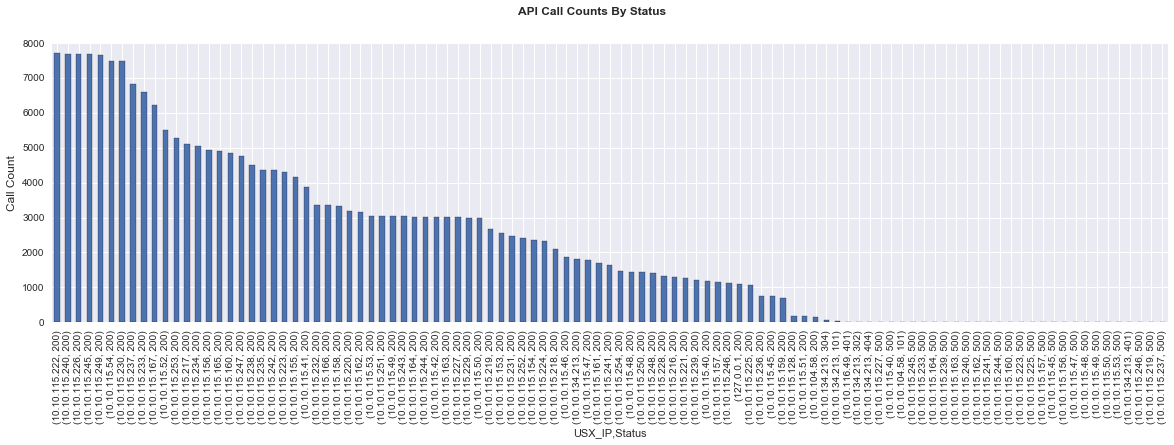

In [257]:
ips_status = get_ip_status_stats(df)
ips_status.sort_values(ascending=False, inplace=True)

fig = plt.figure(figsize=(20, 5))
fig.suptitle('API Call Counts By Status', fontsize=12, fontweight='bold', verticalalignment='baseline')
g = ips_status.plot(kind='bar')
g.set_ylabel("Call Count", fontsize=12);

#df1 = pd.DataFrame({'(USX_IP, API Response)':ips_status.index, 'Count':ips_status.values})
#df1

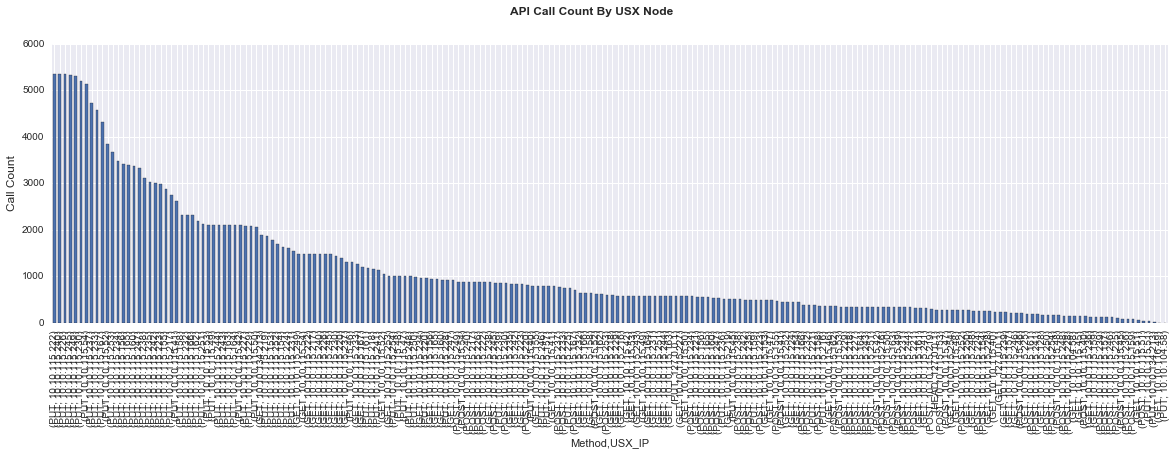

In [258]:
method_ip = get_method_ip_stats(df)
method_ip.sort_values(ascending=False, inplace=True)
fig = plt.figure(figsize=(20, 5))
fig.suptitle('API Call Count By USX Node', fontsize=12, fontweight='bold', verticalalignment='baseline')
g= method_ip.plot(kind='bar')
g.set_ylabel("Call Count", fontsize=12);

In [259]:
print("Details...")
method_ip

Details...


Method  USX_IP       
PUT     10.10.115.222    5353
        10.10.115.240    5349
        10.10.115.226    5348
        10.10.115.245    5340
        10.10.115.249    5316
        10.10.115.230    5193
        10.10.115.54     5130
        10.10.115.237    4730
        10.10.115.233    4578
        10.10.115.167    4311
        10.10.115.52     3837
        10.10.115.253    3665
        10.10.115.234    3490
        10.10.115.156    3425
        10.10.115.165    3402
        10.10.115.160    3367
        10.10.115.247    3323
        10.10.115.238    3114
        10.10.115.235    3024
        10.10.115.242    3014
        10.10.115.223    2991
        10.10.115.155    2882
        10.10.115.217    2756
        10.10.115.41     2616
        10.10.115.158    2331
        10.10.115.232    2331
        10.10.115.166    2328
        10.10.115.162    2196
        10.10.115.251    2116
        10.10.115.53     2115
                         ... 
GET     10.10.115.157     221
        10.10.115.

#### Aggregated on hourly scale....

Hourly aggregated API Call counts by Response Status...


,Bad Gateway,Bad Request,Forbidden,Gateway Timeout,No Content,Not Found,Not Modified,OK,Server Error,UnAuthorized
Time,,,,,,,,,,
2016-10-27 10:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9090,23,2.0
2016-10-27 11:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10909,0,0.0
2016-10-27 12:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11013,0,0.0
2016-10-27 13:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9982,0,0.0
2016-10-27 14:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9469,0,0.0
2016-10-27 15:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8742,0,0.0
2016-10-27 16:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9409,0,0.0
2016-10-27 17:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8469,0,0.0
2016-10-27 18:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8981,0,0.0


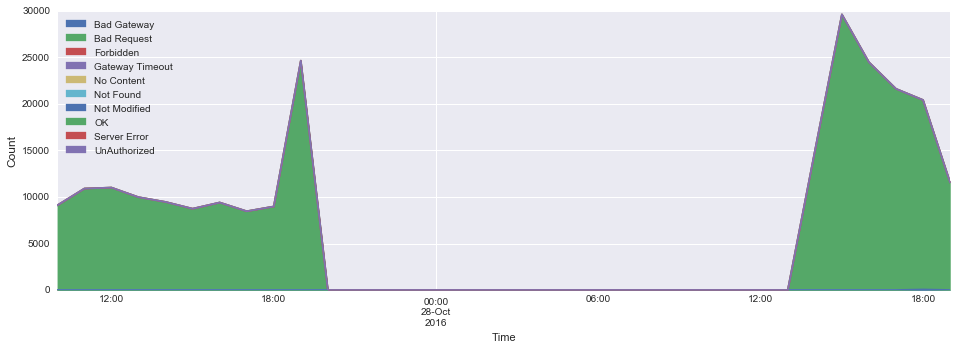

In [260]:
status_df = get_status_details(df)
g = status_df.plot(kind='area', figsize=(16, 5))
g.set_ylabel("Count", fontsize=12);

print("Hourly aggregated API Call counts by Response Status...")
status_df

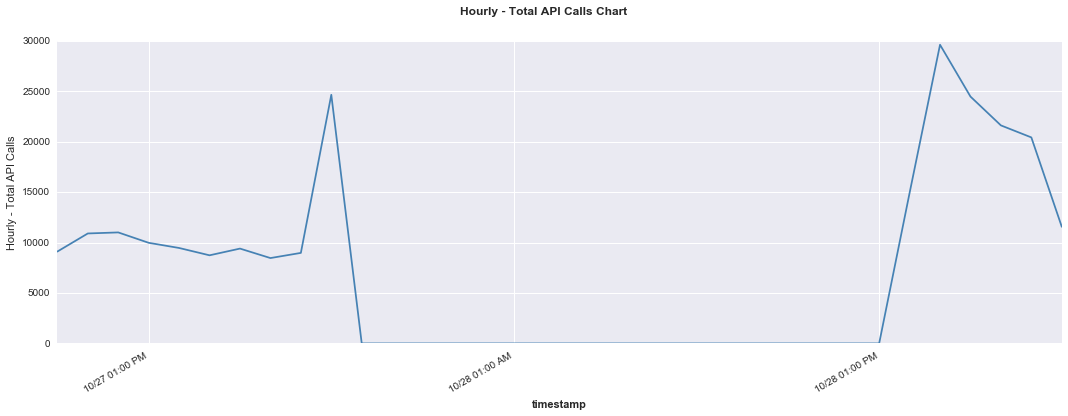

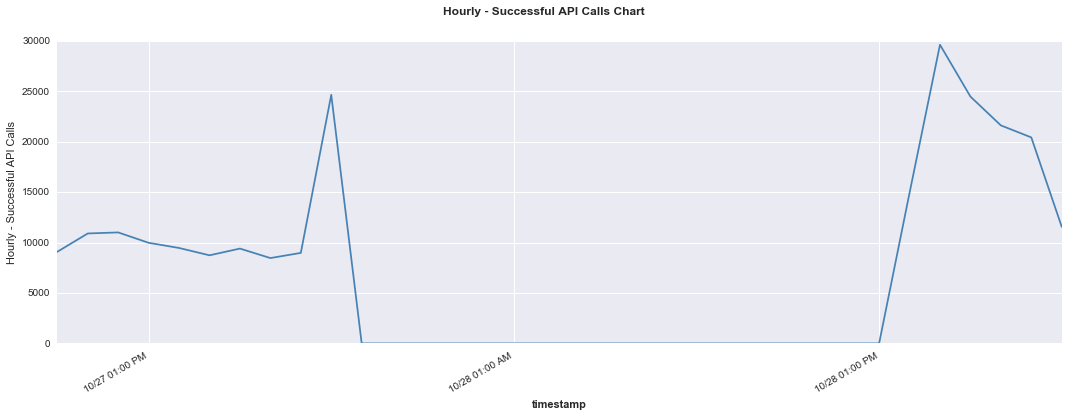

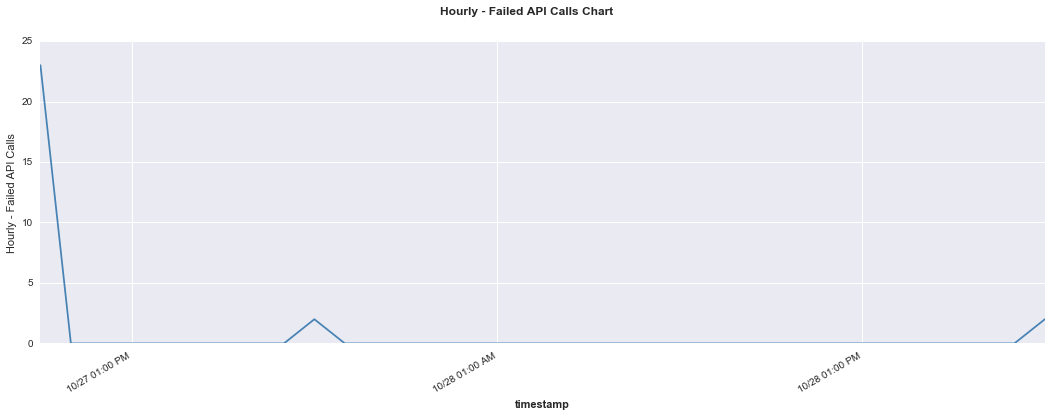

In [261]:
df_s = df['Request'].resample('1H').count()
create_line_plot("Hourly - Total API Calls", df_s)

success_df = df[df['Status'].isin([101, 200, 204, 302, 304, 400, 401, 403, 404])].resample("1H").count()
fail_df = df[df['Status'].isin([499, 500, 502, 504])].resample("1H").count()

create_line_plot("Hourly - Successful API Calls", success_df['Status'])
create_line_plot("Hourly - Failed API Calls", fail_df['Status'])

### Details

In [262]:
print("GET Calls & Counts..")
g1.count().sort_values(by='Method', ascending=False)

GET Calls & Counts..


,,,Method
Request,USX_IP,Status,
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_f1928142-0b83-3a8e-8b26-8caaada8e4d8']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_f1928142-0b83-3a8e-8b26-8caaada8e4d8 HTTP/1.1,10.10.115.249,200,872
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_098d068d-aafc-3974-b9f0-beff92d4df06']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_098d068d-aafc-3974-b9f0-beff92d4df06 HTTP/1.1,10.10.115.54,200,872
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_85706a86-7d1a-3da7-8b11-ae3ef1ca2127']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_85706a86-7d1a-3da7-8b11-ae3ef1ca2127 HTTP/1.1,10.10.115.240,200,870
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_816de0f6-631b-3f0b-ab0d-21d777a1f71e']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_816de0f6-631b-3f0b-ab0d-21d777a1f71e HTTP/1.1,10.10.115.226,200,870
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_d83fd378-957f-3bbf-9217-92229917e570']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_d83fd378-957f-3bbf-9217-92229917e570 HTTP/1.1,10.10.115.222,200,870
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_9a598d0f-fc9e-3538-82f2-8a867057374a']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_9a598d0f-fc9e-3538-82f2-8a867057374a HTTP/1.1,10.10.115.217,200,870
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_a2e284a1-b6cb-39e6-96d1-ba81eae0b019']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_a2e284a1-b6cb-39e6-96d1-ba81eae0b019 HTTP/1.1,10.10.115.245,200,868
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_945ceca1-7a16-3e9d-9101-a8cf0cd6f12f']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_945ceca1-7a16-3e9d-9101-a8cf0cd6f12f HTTP/1.1,10.10.115.230,200,848
GET /usxmanager/usx/inventory/volume/resources?sortby=uuid&query=.[containeruuid='USX_cb306a16-61f8-3c03-97c1-9ba44c677007']&order=ascend&page=0&pagesize=100&cachekey=&fields=uuid&composite=false&api_key=USX_cb306a16-61f8-3c03-97c1-9ba44c677007 HTTP/1.1,10.10.115.220,200,821


In [263]:
print("PUT Calls & Counts..")
g2.count().sort_values(by='Method', ascending=False)

PUT Calls & Counts..


,,,Method
Request,USX_IP,Status,
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_d83fd378-957f-3bbf-9217-92229917e570 HTTP/1.1,10.10.115.222,200,4918
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_85706a86-7d1a-3da7-8b11-ae3ef1ca2127 HTTP/1.1,10.10.115.240,200,4913
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_816de0f6-631b-3f0b-ab0d-21d777a1f71e HTTP/1.1,10.10.115.226,200,4913
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_a2e284a1-b6cb-39e6-96d1-ba81eae0b019 HTTP/1.1,10.10.115.245,200,4905
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_f1928142-0b83-3a8e-8b26-8caaada8e4d8 HTTP/1.1,10.10.115.249,200,4880
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_945ceca1-7a16-3e9d-9101-a8cf0cd6f12f HTTP/1.1,10.10.115.230,200,4769
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_098d068d-aafc-3974-b9f0-beff92d4df06 HTTP/1.1,10.10.115.54,200,4694
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_1167153d-4e06-31b1-9c66-2ac1290ea686 HTTP/1.1,10.10.115.237,200,4342
PUT /usxmanager/usx/inventory/volume/resources/metrics?api_key=USX_a10ee9b6-bce7-3d79-9118-a12798ec4e44 HTTP/1.1,10.10.115.233,200,4201


In [264]:
print("POST Calls & Counts..")
g3.count().sort_values(by='Method', ascending=False)

POST Calls & Counts..


,,,Method
Request,USX_IP,Status,
POST /usxmanager/usx/status/update?api_key=USX_f1928142-0b83-3a8e-8b26-8caaada8e4d8 HTTP/1.1,10.10.115.249,200,873
POST /usxmanager/usx/status/update?api_key=USX_098d068d-aafc-3974-b9f0-beff92d4df06 HTTP/1.1,10.10.115.54,200,872
POST /usxmanager/usx/status/update?api_key=USX_816de0f6-631b-3f0b-ab0d-21d777a1f71e HTTP/1.1,10.10.115.226,200,870
POST /usxmanager/usx/status/update?api_key=USX_d83fd378-957f-3bbf-9217-92229917e570 HTTP/1.1,10.10.115.222,200,870
POST /usxmanager/usx/status/update?api_key=USX_9a598d0f-fc9e-3538-82f2-8a867057374a HTTP/1.1,10.10.115.217,200,870
POST /usxmanager/usx/status/update?api_key=USX_85706a86-7d1a-3da7-8b11-ae3ef1ca2127 HTTP/1.1,10.10.115.240,200,870
POST /usxmanager/usx/status/update?api_key=USX_a2e284a1-b6cb-39e6-96d1-ba81eae0b019 HTTP/1.1,10.10.115.245,200,868
POST /usxmanager/usx/status/update?api_key=USX_945ceca1-7a16-3e9d-9101-a8cf0cd6f12f HTTP/1.1,10.10.115.230,200,849
POST /usxmanager/usx/status/update?api_key=USX_cb306a16-61f8-3c03-97c1-9ba44c677007 HTTP/1.1,10.10.115.220,200,822


In [265]:
print("DELETE Calls & Counts..")
g4.count().sort_values(by='Method', ascending=False)

DELETE Calls & Counts..


,,,Method
Request,USX_IP,Status,


In [266]:
#df1 = pd.DataFrame({'(Method, IP)':method_ip.index, 'Count':method_ip.values})

### Top REST API Calls...

Top 10 REST API Calls...

In [267]:
g = df['Request'].value_counts().head(10) 
df1 = pd.DataFrame({'REST API Call':g.index, 'Count':g.values})
df1

,Count,REST API Call
0,4918,PUT /usxmanager/usx/inventory/volume/resources...
1,4914,PUT /usxmanager/usx/inventory/volume/resources...
2,4913,PUT /usxmanager/usx/inventory/volume/resources...
3,4906,PUT /usxmanager/usx/inventory/volume/resources...
4,4880,PUT /usxmanager/usx/inventory/volume/resources...
5,4769,PUT /usxmanager/usx/inventory/volume/resources...
6,4694,PUT /usxmanager/usx/inventory/volume/resources...
7,4343,PUT /usxmanager/usx/inventory/volume/resources...
8,4202,PUT /usxmanager/usx/inventory/volume/resources...
9,3959,PUT /usxmanager/usx/inventory/volume/resources...


### Stats on REST API whose response size is greater than 2 KB

How many REST API calls whose response size is > 2 KB?

,Call Count,Response Size (KB)
0,18,3.0


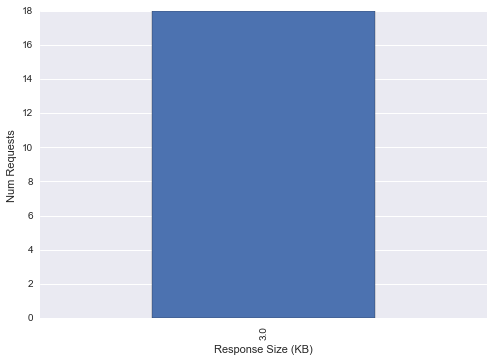

In [268]:
# Choose all requests with the size of the response larger than 2 Kb (remember we convert bytes to KB):
df_2kb = df[df['Size']> 2]
grouped_status = df_2kb.groupby('Size')
g=grouped_status.size().plot(kind='bar')
g.set_xlabel("Response Size (KB)")
g.set_ylabel("Num Requests")

temp = df_2kb['Size'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'Response Size (KB)':temp.index, 'Call Count':temp.values})
df1

Which nodes are invoking these rest api calls and how many calls?

,Call Count,USX_IP
0,18,127.0.0.1


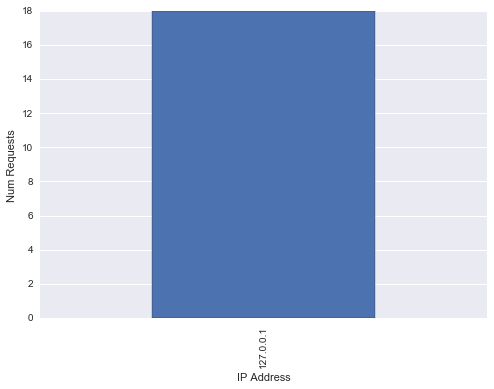

In [269]:
grouped_status2 = df_2kb.groupby('USX_IP')
g=grouped_status2.size().plot(kind='bar')
g.set_xlabel("IP Address")
g.set_ylabel("Num Requests")

temp = df_2kb['USX_IP'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'USX_IP':temp.index, 'Call Count':temp.values})
df1

What are the status of these large rest response api calls and count?

,Call Count,Status (respose_size > 2KB)
0,18,200


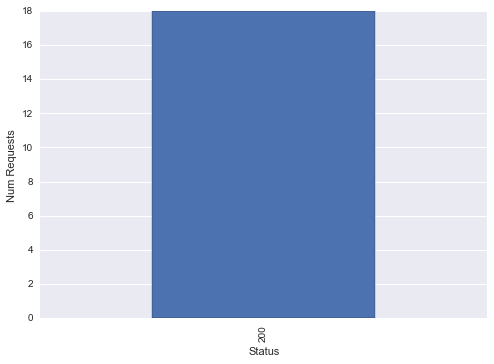

In [270]:
grouped_status1 = df_2kb.groupby('Status')
g=grouped_status1.size().plot(kind='bar')
g.set_xlabel("Status")
g.set_ylabel("Num Requests")

temp = df_2kb['Status'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'Status (respose_size > 2KB)':temp.index, 'Call Count':temp.values})
df1

What are these frequently called REST APIs whose response size > 2KB?

In [271]:
temp = df_2kb['Request'].value_counts()
temp.sort_values(ascending=False, inplace=True)
df1 = pd.DataFrame({'Top APIs (respose_size > 2KB)':temp.index, 'Call Count':temp.values})
df1

,Call Count,Top APIs (respose_size > 2KB)
0,18,GET /usxmanager/license HTTP/1.1


### Additional Investigations...

We have too many calls from 127.0.0.1 (see 1st section for details). What are the calls?

In [272]:
print("Printing last 10 calls from 127.0.0.1...")
df[df.USX_IP =='127.0.0.1'].tail(10)

Printing last 10 calls from 127.0.0.1...


,Status,USX_IP,Method,Request,Size
Time,,,,,
2016-10-28 15:30:32,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/volume/container...,NaN
2016-10-28 15:45:01,200,127.0.0.1,GET,GET /usxmanager/usxmanager HTTP/1.1,2.0
2016-10-28 15:45:30,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/servicevm/contai...,0.0
2016-10-28 15:45:30,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/volume/container...,NaN
2016-10-28 14:45:01,200,127.0.0.1,GET,GET /usxmanager/usxmanager HTTP/1.1,2.0
2016-10-28 14:45:38,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/servicevm/contai...,0.0
2016-10-28 14:45:38,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/volume/container...,NaN
2016-10-28 15:00:01,200,127.0.0.1,GET,GET /usxmanager/usxmanager HTTP/1.1,2.0
2016-10-28 15:00:32,200,127.0.0.1,GET,GET /usxmanager/usx/inventory/servicevm/contai...,0.0
